In [1]:
from google.colab import files
from IPython.display import clear_output
files.upload()
clear_output()

In [2]:
!pip install pycodestyle pycodestyle_magic
!pip install flake8
clear_output()

In [3]:
%load_ext pycodestyle_magic

In [4]:
import re
import time
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
from tqdm.notebook import tqdm
from string import ascii_lowercase
from sklearn.model_selection import train_test_split

%matplotlib inline

In [5]:
torch.manual_seed(42)
np.random.seed(42)
clear_output()

In [ ]:
cudnn.benchmark = True
torch.set_default_tensor_type('cuda')

# Задание 1
## Препроцессинг данных

In [6]:
russian = 'абвгдеёжзийклмнопрстуфхцчшщьыъэюя'
CHAR_TO_INDEX = {w: i for i, w in enumerate(russian)}

In [7]:
def caesar_encode(text, k):
    cipher = ''
    for char in text:
        if char.lower() in russian:
            id = (CHAR_TO_INDEX[char.lower()] + k) % 33
            if char.isupper():
                cipher += russian[id].upper()
            else:
                cipher += russian[id]
        else:
            cipher += char
    return cipher

In [8]:
regex = r'(\[\d+\] \(#litres_trial_promo\)|\[.*\]|\t+)'

# обнаружилась странная ошибка – первое "Не" в тексте оказалось записано латиницей
with open('onegin.txt') as f:
    sents = [re.sub(regex, '', sent).replace('\xa0', ' ').replace('He', 'Не')
             for sent in f.read().splitlines()
             if sent.startswith('\t\t') and not sent.endswith('………')]

In [9]:
len(sents)

1453

In [10]:
sents[:10]

['Не мысля гордый свет забавить,',
 'Вниманье дружбы возлюбя,',
 'Хотел бы я тебе представить',
 'Залог достойнее тебя,',
 'Достойнее души прекрасной,',
 'Святой исполненной мечты,',
 'Поэзии живой и ясной,',
 'Высоких дум и простоты;',
 'Но так и быть – рукой пристрастной',
 'Прими собранье пёстрых глав,']

In [11]:
sents_ciphered = [caesar_encode(sent, 3) for sent in sents]

In [12]:
sents_ciphered[:10]

['Рз пюфов ёсужюм фезх кгдгелхэ,',
 'Ерлпгрэз жуцйдю ескобдв,',
 'Шсхзо дю в хздз тузжфхгелхэ',
 'Кгосё жсфхсмрзз хздв,',
 'Жсфхсмрзз жцыл тузнугфрсм,',
 'Февхсм лфтсорзррсм пзьхю,',
 'Тсаклл йлесм л вфрсм,',
 'Еюфснлш жцп л тусфхсхю;',
 'Рс хгн л дюхэ – уцнсм тулфхугфхрсм',
 'Тулпл фсдугрэз тифхуюш ёоге,']

Посчитаем среднюю длину строки в стихотворении, чтобы выяснить, до какой длины делать padding.

In [13]:
np.mean([len(sent) for sent in sents])

25.044046799724708

In [14]:
MAX_LEN = 25
X = torch.zeros((len(sents), MAX_LEN), dtype=int)
for i in range(len(sents)):
    for j, w in enumerate(sents[i]):
        if j >= MAX_LEN:
            break
        if w == ' ':
            X[i][j] = 34
        if w.lower() in russian:
            X[i][j] = CHAR_TO_INDEX[w.lower()] + 1

In [15]:
X[:10]

tensor([[15,  6, 34, 14, 29, 19, 13, 33, 34,  4, 16, 18,  5, 29, 11, 34, 19,  3,
          6, 20, 34,  9,  1,  2,  1],
        [ 3, 15, 10, 14,  1, 15, 28,  6, 34,  5, 18, 21,  8,  2, 29, 34,  3, 16,
          9, 13, 32,  2, 33,  0,  0],
        [23, 16, 20,  6, 13, 34,  2, 29, 34, 33, 34, 20,  6,  2,  6, 34, 17, 18,
          6,  5, 19, 20,  1,  3, 10],
        [ 9,  1, 13, 16,  4, 34,  5, 16, 19, 20, 16, 11, 15,  6,  6, 34, 20,  6,
          2, 33,  0,  0,  0,  0,  0],
        [ 5, 16, 19, 20, 16, 11, 15,  6,  6, 34,  5, 21, 26, 10, 34, 17, 18,  6,
         12, 18,  1, 19, 15, 16, 11],
        [19,  3, 33, 20, 16, 11, 34, 10, 19, 17, 16, 13, 15,  6, 15, 15, 16, 11,
         34, 14,  6, 25, 20, 29,  0],
        [17, 16, 31,  9, 10, 10, 34,  8, 10,  3, 16, 11, 34, 10, 34, 33, 19, 15,
         16, 11,  0,  0,  0,  0,  0],
        [ 3, 29, 19, 16, 12, 10, 23, 34,  5, 21, 14, 34, 10, 34, 17, 18, 16, 19,
         20, 16, 20, 29,  0,  0,  0],
        [15, 16, 34, 20,  1, 12, 34, 10, 34,  2,

In [16]:
MAX_LEN = 25
y = torch.zeros((len(sents_ciphered), MAX_LEN), dtype=int)
for i in range(len(sents_ciphered)):
    for j, w in enumerate(sents_ciphered[i]):
        if j >= MAX_LEN:
            break
        if w == ' ':
            y[i][j] = 34
        if w.lower() in russian:
            y[i][j] = CHAR_TO_INDEX[w.lower()] + 1

In [17]:
y[:10]

tensor([[18,  9, 34, 17, 32, 22, 16,  3, 34,  7, 19, 21,  8, 32, 14, 34, 22,  6,
          9, 23, 34, 12,  4,  5,  4],
        [ 6, 18, 13, 17,  4, 18, 31,  9, 34,  8, 21, 24, 11,  5, 32, 34,  6, 19,
         12, 16,  2,  5,  3,  0,  0],
        [26, 19, 23,  9, 16, 34,  5, 32, 34,  3, 34, 23,  9,  5,  9, 34, 20, 21,
          9,  8, 22, 23,  4,  6, 13],
        [12,  4, 16, 19,  7, 34,  8, 19, 22, 23, 19, 14, 18,  9,  9, 34, 23,  9,
          5,  3,  0,  0,  0,  0,  0],
        [ 8, 19, 22, 23, 19, 14, 18,  9,  9, 34,  8, 24, 29, 13, 34, 20, 21,  9,
         15, 21,  4, 22, 18, 19, 14],
        [22,  6,  3, 23, 19, 14, 34, 13, 22, 20, 19, 16, 18,  9, 18, 18, 19, 14,
         34, 17,  9, 28, 23, 32,  0],
        [20, 19,  1, 12, 13, 13, 34, 11, 13,  6, 19, 14, 34, 13, 34,  3, 22, 18,
         19, 14,  0,  0,  0,  0,  0],
        [ 6, 32, 22, 19, 15, 13, 26, 34,  8, 24, 17, 34, 13, 34, 20, 21, 19, 22,
         23, 19, 23, 32,  0,  0,  0],
        [18, 19, 34, 23,  4, 15, 34, 13, 34,  5,

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Архитектура RNN

In [19]:
class CaesarNetwork(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(CaesarNetwork, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.rnn = torch.nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.dense = torch.nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, train=True, state=None):
        with torch.set_grad_enabled(train):
            out = self.embedding(x)
            out, state = self.rnn(out, state)
            out = self.dense(out)
            out = out.squeeze(0)
        return out, state

## Обучение

In [20]:
vocab_size = 35
embedding_dim = 35
hidden_dim = 128

In [21]:
model = CaesarNetwork(vocab_size, embedding_dim, hidden_dim)

In [22]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
batch_size = 64
n_epochs = 100

In [23]:
train_losses = []

for epoch in tqdm(range(1, n_epochs + 1)):
    start = time.time()
    train_loss = 0.0
    for i in range(int(np.ceil(len(X_train) / batch_size))):
        X_batch = X_train[batch_size * i: batch_size * (i + 1)]
        y_batch = y_train[batch_size * i: batch_size * (i + 1)].flatten()
        optimizer.zero_grad()
        y_pred, _ = model.forward(X_batch)
        loss = criterion(y_pred.view(-1, 35), y_batch)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(train_loss)
    sec = time.time() - start
    print(f'Epoch: {epoch}, time: {sec:.1f}s, train loss: {train_loss:.3f}')

Epoch: 1, time: 0.6s, train loss: 55.630
Epoch: 2, time: 0.3s, train loss: 39.739
Epoch: 3, time: 0.3s, train loss: 29.037
Epoch: 4, time: 0.3s, train loss: 22.182
Epoch: 5, time: 0.3s, train loss: 17.629
Epoch: 6, time: 0.3s, train loss: 14.397
Epoch: 7, time: 0.3s, train loss: 11.981
Epoch: 8, time: 0.3s, train loss: 10.118
Epoch: 9, time: 0.3s, train loss: 8.655
Epoch: 10, time: 0.3s, train loss: 7.491
Epoch: 11, time: 0.3s, train loss: 6.554
Epoch: 12, time: 0.3s, train loss: 5.792
Epoch: 13, time: 0.3s, train loss: 5.165
Epoch: 14, time: 0.3s, train loss: 4.643
Epoch: 15, time: 0.3s, train loss: 4.202
Epoch: 16, time: 0.3s, train loss: 3.826
Epoch: 17, time: 0.3s, train loss: 3.503
Epoch: 18, time: 0.3s, train loss: 3.223
Epoch: 19, time: 0.3s, train loss: 2.979
Epoch: 20, time: 0.3s, train loss: 2.764
Epoch: 21, time: 0.3s, train loss: 2.574
Epoch: 22, time: 0.3s, train loss: 2.405
Epoch: 23, time: 0.3s, train loss: 2.254
Epoch: 24, time: 0.3s, train loss: 2.119
Epoch: 25, time: 

# Оценка качества
Построим график лоссов на обучающей выборке и оценим качество на тестовой.

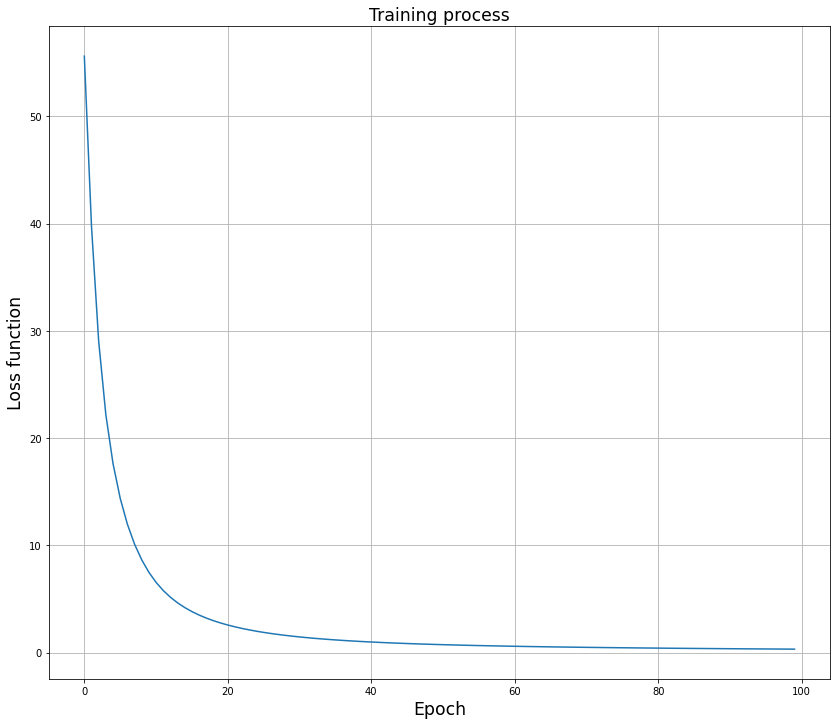

In [24]:
plt.figure(figsize=(14, 12))
plt.plot(train_losses)
plt.grid()
plt.title('Training process', fontsize='xx-large')
plt.xlabel('Epoch', fontsize='xx-large')
plt.ylabel('Loss function', fontsize='xx-large')
plt.show()

In [25]:
y_pred, _ = model.forward(X_test, train=False)
loss = criterion(y_pred.view(-1, 35), y_test.flatten())

In [26]:
print(f'Лосс на тестовой выборке: {loss.item():.3f}')

Лосс на тестовой выборке: 0.022


Очень неплохо!

# Задание 2
## Препроцессинг данных

In [27]:
df = pd.read_csv('data.csv')

In [28]:
df.head()

,Unnamed: 0,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,0,10368,35,29,"Lisa Simpson: Maggie, look. What's that?",235000,True,9,5.0,Lisa Simpson,Simpson Home,"Maggie, look. What's that?",maggie look whats that,4.0
1,1,10369,35,30,Lisa Simpson: Lee-mur. Lee-mur.,237000,True,9,5.0,Lisa Simpson,Simpson Home,Lee-mur. Lee-mur.,lee-mur lee-mur,2.0
2,2,10370,35,31,Lisa Simpson: Zee-boo. Zee-boo.,239000,True,9,5.0,Lisa Simpson,Simpson Home,Zee-boo. Zee-boo.,zee-boo zee-boo,2.0
3,3,10372,35,33,Lisa Simpson: I'm trying to teach Maggie that ...,245000,True,9,5.0,Lisa Simpson,Simpson Home,I'm trying to teach Maggie that nature doesn't...,im trying to teach maggie that nature doesnt e...,24.0
4,4,10374,35,35,"Lisa Simpson: It's like an ox, only it has a h...",254000,True,9,5.0,Lisa Simpson,Simpson Home,"It's like an ox, only it has a hump and a dewl...",its like an ox only it has a hump and a dewlap...,18.0


In [29]:
sents = df['normalized_text'].tolist()

In [30]:
len(sents)

11639

In [31]:
sents[:10]

['maggie look whats that',
 'lee-mur lee-mur',
 'zee-boo zee-boo',
 'im trying to teach maggie that nature doesnt end with the barnyard i want her to have all the advantages that i didnt have',
 'its like an ox only it has a hump and a dewlap hump and dew-lap hump and dew-lap',
 'you know his blood type how romantic',
 'oh yeah whats my shoe size',
 'ring',
 'yes dad',
 'ooh look maggie what is that do-dec-ah-edron dodecahedron']

In [32]:
text = [[char for char in sent] for sent in sents if isinstance(sent, str)]

In [33]:
text[0]

['m',
 'a',
 'g',
 'g',
 'i',
 'e',
 ' ',
 'l',
 'o',
 'o',
 'k',
 ' ',
 'w',
 'h',
 'a',
 't',
 's',
 ' ',
 't',
 'h',
 'a',
 't']

In [34]:
CHAR_TO_INDEX = {w: i for i, w in enumerate(ascii_lowercase)}

Посчитаем среднюю длину реплики, чтобы выяснить, до какой длины делать padding.

In [35]:
np.mean([len(sent) for sent in text])

46.36635754292535

Да, действительно, лучше до 50.

In [36]:
MAX_LEN = 50
X = torch.zeros((len(text), MAX_LEN), dtype=int)
for i in range(len(text)):
    for j, w in enumerate(text[i]):
        if j >= MAX_LEN:
            break
        if w == ' ':
            X[i][j] = 27
        if w.lower() in ascii_lowercase:
            X[i][j] = CHAR_TO_INDEX[w.lower()] + 1

In [37]:
X[:10]

tensor([[13,  1,  7,  7,  9,  5, 27, 12, 15, 15, 11, 27, 23,  8,  1, 20, 19, 27,
         20,  8,  1, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [12,  5,  5,  0, 13, 21, 18, 27, 12,  5,  5,  0, 13, 21, 18,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [26,  5,  5,  0,  2, 15, 15, 27, 26,  5,  5,  0,  2, 15, 15,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 9, 13, 27, 20, 18, 25,  9, 14,  7, 27, 20, 15, 27, 20,  5,  1,  3,  8,
         27, 13,  1,  7,  7,  9,  5, 27, 20,  8,  1, 20, 27, 14,  1, 20, 21, 18,
          5, 27,  4, 15,  5, 19, 14, 20, 27,  5, 14,  4, 27, 23],
        [ 9, 20, 19, 27, 12,  9, 11,  5, 27,  1, 14, 27, 15, 24, 27, 15, 14, 12,
       

## Архитектура RNN

In [48]:
class TextGenerationNetwork(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(TextGenerationNetwork, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.rnn = torch.nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.dense = torch.nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, train=True, state=None):
        with torch.set_grad_enabled(train):
            out = self.embedding(x)
            out, state = self.rnn(out)
            out = self.dense(out)
            out = out.squeeze(0)
        return out, state

In [49]:
sent_as_tensors = [torch.as_tensor(np.array([[CHAR_TO_INDEX[char] + 1]]),
                                   dtype=torch.long)
                   for char in ['h', 'e', 'l', 'l', 'o']]

In [50]:
# я решила добавить ограничение на длину сгенерированного предложения
def generate_sentence(model):
    sent = 'hello'
    state = None
    for char in sent_as_tensors:
        out, state = model.forward(char, train=False, state=state)
    id = np.argmax(out.numpy().flatten())
    while id != 0 and len(sent) < MAX_LEN:
        if id == 27:
            sent += ' '
        else:
            sent += ascii_lowercase[id - 1]
        out, state = model.forward(torch.as_tensor(np.array([[id]]),
                                                   dtype=torch.long),
                                   train=False)
        id = np.argmax(out.numpy().flatten())
    return sent

## Обучение и генерация предложений на каждой эпохе

In [51]:
vocab_size = 28
embedding_dim = 28
hidden_dim = 128

In [52]:
model = TextGenerationNetwork(vocab_size, embedding_dim, hidden_dim)

In [53]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
batch_size = 100
n_epochs = 100

In [54]:
train_losses = []

for epoch in tqdm(range(1, n_epochs + 1)):
    start = time.time()
    train_loss = 0.0
    for i in range(int(np.ceil(len(X_train) / batch_size))):
        batch = X[i * batch_size: (i + 1) * batch_size]
        X_batch = batch[:, :-1]
        y_batch = batch[:, 1:].flatten()
        optimizer.zero_grad()
        y_pred, _ = model.forward(X_batch)
        loss = criterion(y_pred.view(-1, 28), y_batch)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(train_loss)
    sec = time.time() - start
    print(f'Epoch: {epoch}, time: {sec:.1f}s, train loss: {train_loss:.3f}')
    print(generate_sentence(model) + '\n')

Epoch: 1, time: 0.5s, train loss: 29.926
hello

Epoch: 2, time: 0.5s, train loss: 23.903
hello w w w w w w w w w w w w w w w w w w w w w w 

Epoch: 3, time: 0.5s, train loss: 22.953
hello w w w w w w w w w w w w w w w w w w w w w w 

Epoch: 4, time: 0.5s, train loss: 22.193
hello t t t t t t t t t t t t t t t t t t t t t t 

Epoch: 5, time: 0.5s, train loss: 21.528
hello t t t t t t t t t t t t t t t t t t t t t t 

Epoch: 6, time: 0.5s, train loss: 21.033
hello t t t t t t t t t t t t t t t t t t t t t t 

Epoch: 7, time: 0.5s, train loss: 20.661
hello t t t t t t t t t t t t t t t t t t t t t t 

Epoch: 8, time: 0.5s, train loss: 20.360
hello t t t t t t t t t t t t t t t t t t t t t t 

Epoch: 9, time: 0.5s, train loss: 20.114
hello t t t t t t t t t t t t t t t t t t t t t t 

Epoch: 10, time: 0.5s, train loss: 19.910
hello t t t t t t t t t t t t t t t t t t t t t t 

Epoch: 11, time: 0.5s, train loss: 19.734
hello t t t t t t t t t t t t t t t t t t t t t t 

Epoch: 12, time: 0.5

Фигню какую-то генерирует, и loss слишком большой (но хотя бы падает!). Что-то я делаю не так. <br>
Построим график лоссов.

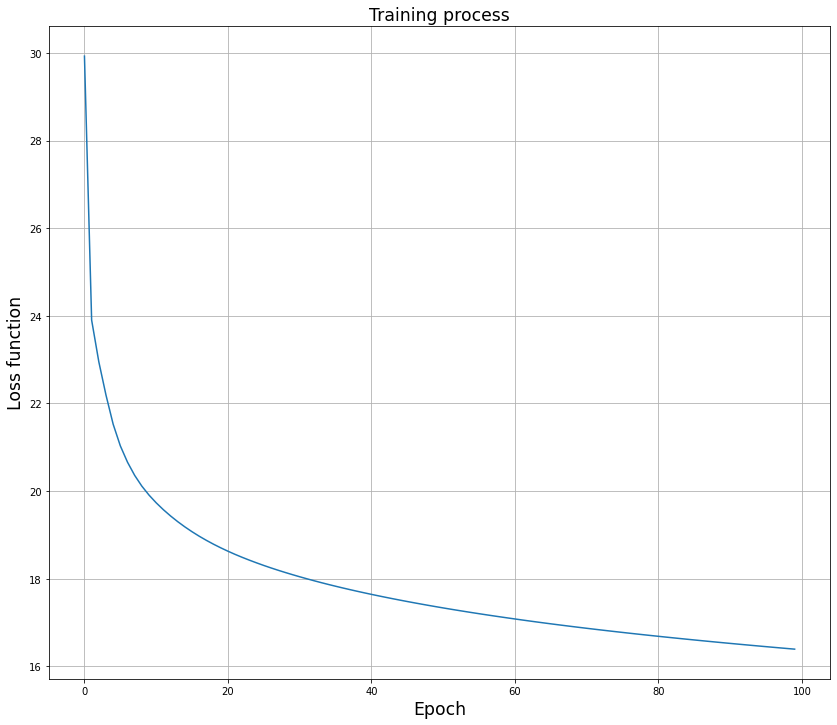

In [55]:
plt.figure(figsize=(14, 12))
plt.plot(train_losses)
plt.grid()
plt.title('Training process', fontsize='xx-large')
plt.xlabel('Epoch', fontsize='xx-large')
plt.ylabel('Loss function', fontsize='xx-large')
plt.show()